In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info import Operator

from qiskit.tools.visualization import plot_histogram
from IPython.display import display, Math, Latex

# Grover's Algorithm

Grover's Algorithm is a non-deterministic Quantum Algorithm proposed by Lov Grover in 1996, that is usually known to solve the problem of "Searching a element into an unsorted database", which with high probability finds the searched given element, using just $\mathcal{O}(\sqrt{N})$ queries. The analogous classical solution for this same problem needs at the worst case $\mathcal{O}(N)$ operations.

Even though Grover's Algorithm doesn't give us a exponential speedup, this Quantum approach still provide us a quadratic improvement over the classical solution, which is still pretty useful when dealing with large $N$ inputs, and as already shown by Bennett, Bernstein, Brassard, and Vazirani Grover's algorithm is asymptotically optimal, since any quantum solution for the same problem needs at least $\Omega(\sqrt{N})$ queries.

<img src="images/grover_blue.jpg" style="width:500px; height:300px"/>

## The Algorithm

As already stated in the introduction, Grover's algorithm goal is to find a element $w$ in a given database of size $N = 2^n$, where $n$ is the number of qubits. The main idea of the algorithm, consists in marking the given element such as its probability of measurment is increased, which will be done by guess what? Our dear friend the $U_f$ function $f:\{0, 1\}^n \rightarrow \{0, 1\}$, which is pretty much the same that is done in Deutsch-Josza algorithm, if your a not familiar with his idea, I strongly recommend you to take a look in the [Deutsch-Josza Algorithm](https://github.com/matheusmtta/Quantum-Computing/blob/master/Algorithms/Deutsch-Josza.ipynb) Notebook.

Therefore, let $|x\rangle$ be a quantum state on $n$ qubits, we will define our $U_w$ operator by the following

$$
\begin{cases}
    U_f|x\rangle &= -|x\rangle, \text{ if } x = w, \text{then } f(x) = 1 \\
    U_f|x\rangle &=  |x\rangle, \text{ if } x \neq w, \text{then } f(x) = 0 \\
\end{cases}
$$

We have shown an alternative solution for the problem of building the $U_f$ gate in the DJ Algorithm notebook using $CNOT$ gates and a ancilla qubit $|y\rangle$, that give us a phase kick-back on the elements that we are willing to mark, however we will use a different approach in Grover's Algorithm.

Besides the $U_w$ operator we will need another gate $U_{f_{0}} = 2|0\rangle\langle 0| - I$, that is known as the diffusor opperator of our circuit, briefly speaking it is used to create the amplitude amplification, by applying a revolution over the medium value of the amplitudes. 

Hence, we have the following operators

$$
    U_f = I - 2|w\rangle\langle w|\\
    U_{f_0} = 2|0\rangle^{\otimes n}\langle0|^{\otimes n} - I
$$

But for the purpose of our following statements, lets define the diffusor operator as $D = H^{\otimes n}U_{f_0}H^{\otimes n}$.

Now that we know the gates that will be used by our circuit, we can go through each step of the algorithm protocol.

<img src="images/grover_circuit.jpg" style="width:500px; height:200px"/>

Now that we have our circuit, lets claim that our measured result at the end of the circuit $z = w$ with high probability.

To show that, lets define as $|s\rangle$ as the n-dimensional 'zero' superposition state

$$
    |s\rangle = H^{\otimes n}|0\rangle^{\otimes n} = \frac{1}{\sqrt{2^n}}\sum_{x \in \{0, 1\}^n}|x\rangle
$$

And now lets derive the definition about D made above

$$
    \begin{align*}
        D &= H^{\otimes n}U_{f_0}H^{\otimes n}\\
          &= H^{\otimes n}(2|0\rangle^{\otimes n}\langle0|^{\otimes n} - I)H^{\otimes n}\\
          &= H^{\otimes n}2|0\rangle^{\otimes n}\langle0|^{\otimes n}H^{\otimes n} - H^{\otimes n}IH^{\otimes n}\\
          &= |s\rangle\langle s| - I
    \end{align*}
$$

From that we have the revolution above the medium of the amplitude values, and we can say that grovers works carrying the operation $(DU_f)^{\mathcal{O}(\sqrt{N})}$ on the state $|s\rangle$.

Now let $\Sigma$ be the plane spanned by $|w\rangle$ and $|s\rangle$, and $|w^{\perp}\rangle$ the orthogonal state to $|w\rangle \in \Sigma$, so that $|w^{\perp}\rangle = \frac{1}{\sqrt{2^n - 1}}\sum_{x \in \{0, 1\}^n\text{, } x \neq w}|x\rangle$. Therefore we have that $|s\rangle$ can be defined as

$$
    \begin{align*}
        |s\rangle &= \sqrt{\frac{2^n-1}{2^n}}|w^\perp\rangle + \frac{1}{\sqrt{2^n}}|w\rangle\\
                  &= \cos \frac{\theta}{2}|w^\perp\rangle + \sin\frac{\theta}{2}|w\rangle
    \end{align*}
$$

And from that we can take that $\sin\frac{\theta}{2} = \frac{1}{\sqrt{2^n}} \Rightarrow \theta = 2\arcsin\frac{1}{\sqrt{2^n}}$

<img src="images/grover_step0.png" style="width:500px; height:380px"/>

Finally, now to complete our claim demonstration, we will go through the algorithm step by step, and see how $U_f$ and $D$ applied $\mathcal{O}(\sqrt{N})$ into $|s\rangle$ give us the solution for our problem.

**Step 0.** First we initialize all of ours $n$ qubits at the $|0\rangle$ state.
$$
\begin{align*}
|\psi\rangle = |0\rangle^{\otimes n}
\end{align*}
$$

**Step 1.** Then we apply the Hadamard gates to put our state $|\psi\rangle$ on superposition. 
$$
\begin{align*}
|s\rangle = H^{\otimes n}|\psi\rangle = \frac{1}{\sqrt{2^n}}\sum_{x \in \{0, 1\}^n}|x\rangle
\end{align*}
$$

**Step 2.** After that we apply the $U_f = I - 2|w\rangle\langle w|$ gate that will work as phase operator given by $f(x)$, that geometrically can be seen as reflection at $|w\rangle$ of size $\frac{\theta}{2}$, given by the inner product $\langle w|s\rangle$.

<img src="images/grover_step1.png" style="width:500px; height:380px"/>

**Step 3.** Now to diffuse our amplitudes we apply $D = |s\rangle\langle s| - I$ into our state $U_f|s\rangle$, which geometrically as we have seen above is a reflection at $|s\rangle$, given by the inner product between $\langle s|U_fs\rangle$. That will rotate our vector $|s\rangle$ towards our winner vector $|w\rangle$ by a angle $\theta$. 

<img src="images/grover_step2.png" style="width:500px; height:380px"/>

From these steps, after applications of **Step 2** and **Step 3**, $|s\rangle$ is rotated towards $|w\rangle$ $r\theta$, for $r \in \mathbb{Z}$. So we must choose $r$, so that,

$$r\theta + \frac{\theta}{2} \simeq \frac{\pi}{2}$$

Therefore, from our previous definition we have that

$$
    \begin{align*}
        r &= \frac{\pi}{2\theta} - \frac{1}{2}\\
          &= \frac{\pi}{4\arcsin \frac{1}{\sqrt{2^n}}}- \frac{1}{2}\\
          &\simeq \frac{\pi}{4}\sqrt{2^n}\\
          &= \mathcal{O}(\sqrt{N})
    \end{align*}
$$

Hence, after $r$ calls, the probability of measuring $w$ at $z$ wil be

$$
    \begin{align*}
        P(w) &\geq 1 - \sin^2\frac{\theta}{2}\\
             &=     1 - \frac{1}{2^n}
    \end{align*}
$$

Which show us that after $r = \mathcal{O}(\sqrt{N})$ we will have the right outcome with high probability, as we were willing demonstrate. 

### Multiple Marked Elements

Further, with Grover's Algorithm we're able to mark more than one element $w$, i.e, we can define a vector of $M$ marked eleemnts $w_i$, where will state our winning state $|w\rangle$ and $|w\perp\rangle$ as

$$
    \begin{align*}
        |w\rangle = \frac{1}{\sqrt{M}}\sum_{i = 1}^{M}|w_i\rangle \qquad |w^\perp\rangle = \frac{1}{\sqrt{N-M}}\sum_{x \in \{0, 1\}^n\text{, } x \notin w}|x\rangle
    \end{align*}
$$

From that we can define our superposition state $|s\rangle$ as

$$
    \begin{align*}
        |s\rangle &= \sqrt{\frac{N-M}{N}}|w^\perp\rangle + \sqrt{\frac{M}{N}}|w\rangle\\
                  &= \cos\frac{\theta}{2}|w^\perp\rangle + \sin\frac{\theta}{2}|w\rangle
    \end{align*}
$$

And can be easily seen that $\sin\frac{\theta}{2} = \sqrt{\frac{M}{N}}$, which give us that $\theta$ becames larger, so our protocol finds our winning state faster, i.e, our algorithm becames more efficient as the number of marked elements grows. Therefore our approximate number of iterations $r$ is given by
 
$$
    \begin{align*}
        r &= \frac{\pi}{4\arcsin\big(\sqrt{\frac{M}{N}}\big)} - \frac{1}{2}\\
          &= \mathcal{O}\bigg(\sqrt{\frac{N}{M}}\bigg)
    \end{align*}
$$

## Implementation

Finally, now we are able to implement the Grover's algorithm protocol using IBM qiskit

In [2]:
#define the Uf operator I - 2|w><w|
def Uf(n, marked_elements):
    #create an ancilla circuit named Uf
    anc_circ = QuantumCircuit(n, name = 'Uf')
    U = np.eye(2**n)
    
    for i in marked_elements:
        U[i][i] = -1
        
    anc_circ.unitary(Operator(U), range(n))
    
    return anc_circ

In [3]:
#define the D operator 2|s><s| - I
def Diffuser(n):
    #create an ancilla circuit named Diffused
    anc_circ = QuantumCircuit(n, name = 'Diffuser')
    
    anc_circ.h(range(n))
    anc_circ.append(Uf(n, [0]), range(n))
    anc_circ.h(range(n))
    
    return anc_circ

In [4]:
def Grover(n, w):
    #initialize qubits and measurement bits
    input_qubits = QuantumRegister(n)
    output_bits = ClassicalRegister(n)

    #create circuit
    my_circuit = QuantumCircuit(input_qubits, output_bits)

    #apply Hadamard on all qubits
    my_circuit.h(range(n))

    r = int(np.floor(np.pi/4*np.sqrt(2**n/len(w))))

    my_circuit.barrier()

    for i in range(r):
        my_circuit.append(Uf(n, w), range(n))
        my_circuit.append(Diffuser(n), range(n))

    my_circuit.barrier()

    my_circuit.measure(range(n), range(n))
    
    return my_circuit

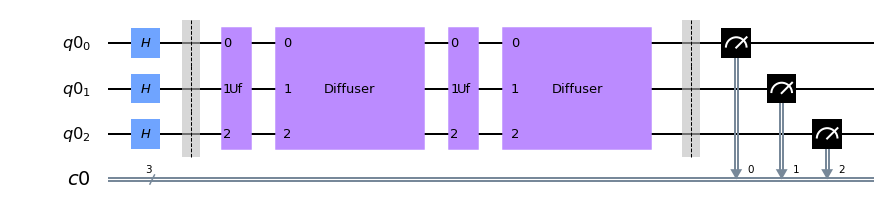

In [5]:
#input size
n = 3

#marked elements
w_1 = [6]
my_circuit = Grover(n, w_1)

#Backend classical simulation
backend = BasicAer.get_backend('qasm_simulator')
atp = 1024
res = execute(my_circuit, backend=backend, shots=atp).result()
ans = res.get_counts()
my_circuit.draw(output='mpl')

In [6]:
my_circuit = transpile(my_circuit,basis_gates=['cx','u3'],optimization_level=3)

#Backend Quantum
provider = IBMQ.get_provider(group='open', project='main')
backend = provider.get_backend('ibmq_ourense')
job = execute(my_circuit, backend=backend, shots=atp)
ans_quantum = job.result().get_counts()

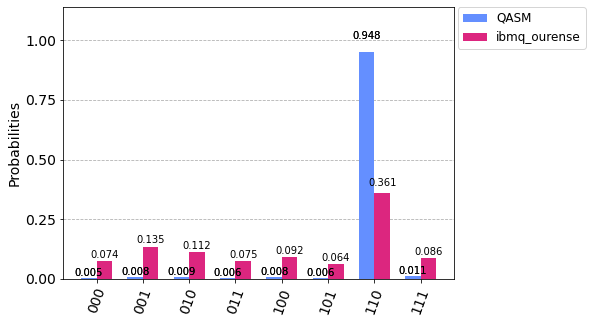

In [7]:
legend = ['QASM','ibmq_ourense']
plot_histogram([ans,ans_quantum], legend=legend)

In [8]:
#Now we will mark two elements
w_2 = [0, 1]
my_circuit = Grover(n, w_2)
my_circuit = transpile(my_circuit,basis_gates=['cx','u3'],optimization_level=3)

In [9]:
#Backend classical simulation
backend = BasicAer.get_backend('qasm_simulator')
atp = 1024
res = execute(my_circuit, backend=backend, shots=atp).result()
ans = res.get_counts()

#Backend Quantum
provider = IBMQ.get_provider(group='open', project='main')
backend = provider.get_backend('ibmq_ourense')
job = execute(my_circuit, backend=backend, shots=atp)
ans_quantum = job.result().get_counts()

ibmqfactory.load_account:WARNING:2020-07-29 00:19:20,136: Credentials are already in use. The existing account in the session will be replaced.


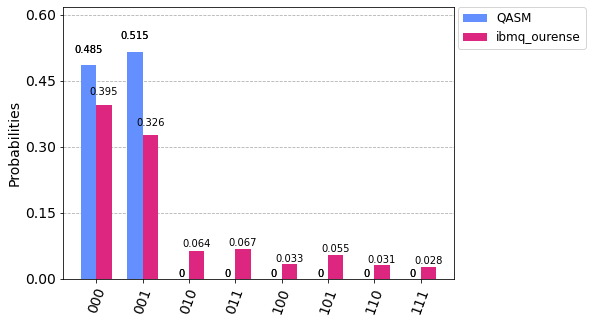

In [10]:
legend = ['QASM','ibmq_ourense']
plot_histogram([ans,ans_quantum], legend=legend)

## References

__[Wikipedia Grover Algorithm](https://en.wikipedia.org/wiki/Grover%27s_algorithm)__\
__[Learn Quantum Computation using Qiskit](https://community.qiskit.org/textbook/)__\
__[Grovers Algorithm IBM Qiskit](https://qiskit.org/textbook/ch-algorithms/grover.html)__\
__[Image 1](https://www.tweeddailynews.com.au/news/did-grover-drop-the-fbomb-on-sesame-street/3611248/)__